<a href="https://colab.research.google.com/github/sodia1/hello-world/blob/master/Copy_of_Model_Serving_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!rm -r tfmodel

rm: cannot remove 'tfmodel': No such file or directory


In [0]:
!pip install tensorflow==1.11

In [0]:
# Importing the necessary libraries
import tensorflow as tf
import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline

# checking the tensorflow version
print(tf.__version__)

1.11.0


In [0]:
# Loading the mnist data from the inbuit datasets
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# reshaping the image into a 1D numpy array and Normalizing the data
train_images = train_images.reshape(-1, 28 * 28) / 255.0
test_images = test_images.reshape(-1, 28 * 28) / 255.0

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
def encode_labels(labels):
    """
    :param labels: labels from dataset
    :return: One-Hot encoded labels
    """
    return np.eye(10)[labels]

In [0]:
# Encoding the training data
print("Printing the first label: ", train_labels[0])
encoded_train_labels = encode_labels(train_labels)
encoded_test_labels = encode_labels(test_labels)
print("Printing the first one-hot encoded label: ", encoded_train_labels[0])

# Printing the shape
print("shape of labels(Before encoding) :", train_labels.shape)
print("shape of labels(After encoding) :", encoded_train_labels.shape)

Printing the first label:  5
Printing the first one-hot encoded label:  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
shape of labels(Before encoding) : (60000,)
shape of labels(After encoding) : (60000, 10)


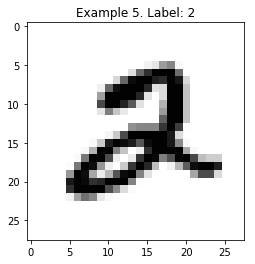

In [0]:
def display(index):
    """
    :param index: index of the image in training data
    """
    img = train_images[index]
    plt.title('Example %d. Label: %d' % (index, train_labels[index]))
    plt.imshow(img.reshape((28,28)), cmap=plt.cm.gray_r)
    
display(5)

In [0]:
# Hyperparamters Config

learning_rate = 0.01
epochs = 100
checkpoint_save_path = './tfmodel/'
model_save_path = checkpoint_save_path + 'model/'

In [0]:
# Starting the tensorflow session
sess = tf.Session()

# Creating the placeholders for the inputs(images) and outputs(labels)
x = tf.placeholder(tf.float32, shape=[None, 784], name="x")
y = tf.placeholder(tf.float32, shape=[None, 10], name="labels")

# Creating a simple neural network
denseLayer1 = tf.layers.dense(x, 512, activation=tf.nn.relu, name='fullyConnectedLayer1')
dropoutLayer2 = tf.nn.dropout(denseLayer1, keep_prob=0.2)
logits = tf.layers.dense(dropoutLayer2, 10, name="output")

# saving the error into a scalar variable
with tf.name_scope("error"):
    error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=y), name="error")
    tf.summary.scalar("error", error)

# Defining the Adam Optimizer
with tf.name_scope("train"):
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(error)

# Saving the accuracy to the scalar
with tf.name_scope("accuracy"):
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    tf.summary.scalar("accuracy", accuracy)

# Summarizing all the summaries
summ = tf.summary.merge_all()

# Initializing the saver for creating the checkpoints
saver = tf.train.Saver()

# Initializing all global variables 
sess.run(tf.global_variables_initializer())

# Defining the save path
writer = tf.summary.FileWriter(checkpoint_save_path)
writer.add_graph(sess.graph)


In [0]:
for i in range(1, epochs+1):
    
    # evaulating the train_step from the given inputs
    sess.run(train_step, feed_dict={x: train_images, y: encoded_train_labels})
    
    # Computing the summary and writing to the tensorboard
    # [train_accuracy, s] = sess.run([accuracy, summ], feed_dict={x: train_images, y: encoded_train_labels})
    [test_accuracy, s] = sess.run([accuracy, summ], feed_dict={x: test_images, y: encoded_test_labels})
    writer.add_summary(s, i)
    
    # Writing every 5th epoch
    if i%5 == 0:
      print("epoch: {0:} accuracy: {1:.6f}".format(i, test_accuracy*100))
    
    # Saving it as a checkpoint
    saver.save(sess, os.path.join(checkpoint_save_path, "model.ckpt"), i)

epoch: 5 accuracy: 76.289999
epoch: 10 accuracy: 85.100001
epoch: 15 accuracy: 88.559997
epoch: 20 accuracy: 89.899999
epoch: 25 accuracy: 90.829998
epoch: 30 accuracy: 91.560000
epoch: 35 accuracy: 92.240000
epoch: 40 accuracy: 92.519999
epoch: 45 accuracy: 93.099999
epoch: 50 accuracy: 93.260002
epoch: 55 accuracy: 93.760002
epoch: 60 accuracy: 93.809998
epoch: 65 accuracy: 93.709999
epoch: 70 accuracy: 94.029999
epoch: 75 accuracy: 94.330001
epoch: 80 accuracy: 94.279999
epoch: 85 accuracy: 94.250000
epoch: 90 accuracy: 94.360000
epoch: 95 accuracy: 94.599998
epoch: 100 accuracy: 94.760001


In [0]:
# Initializing the tensorflow save builder
builder = tf.saved_model.builder.SavedModelBuilder(model_save_path)

# Computing the input and output tensor information 
tensor_info_x = tf.saved_model.utils.build_tensor_info(x)
tensor_info_y = tf.saved_model.utils.build_tensor_info(logits)

# Creating the prediction signature
prediction_signature = (
    tf.saved_model.signature_def_utils.build_signature_def(
        inputs={'images': tensor_info_x},
        outputs={'scores': tensor_info_y},
        method_name=tf.saved_model.signature_constants.PREDICT_METHOD_NAME
    )
)

# Adding the signature to the graph
builder.add_meta_graph_and_variables(
      sess, [tf.saved_model.tag_constants.SERVING],
      signature_def_map={
          'predict_images':
              prediction_signature
      }
)

# Saving the model (production serving model)
builder.save()

INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: ./tfmodel/model/saved_model.pb


b'./tfmodel/model/saved_model.pb'

In [0]:
!zip -r tfmodel.zip tfmodel

  adding: tfmodel/ (stored 0%)
  adding: tfmodel/model.ckpt-96.meta (deflated 86%)
  adding: tfmodel/model.ckpt-100.data-00000-of-00001 (deflated 12%)
  adding: tfmodel/model.ckpt-98.meta (deflated 86%)
  adding: tfmodel/model.ckpt-99.index (deflated 38%)
  adding: tfmodel/model.ckpt-100.meta (deflated 86%)
  adding: tfmodel/events.out.tfevents.1567512587.c4b8c7277b2f (deflated 86%)
  adding: tfmodel/model.ckpt-97.data-00000-of-00001 (deflated 12%)
  adding: tfmodel/model.ckpt-99.meta (deflated 86%)
  adding: tfmodel/checkpoint (deflated 75%)
  adding: tfmodel/model.ckpt-96.index (deflated 38%)
  adding: tfmodel/model/ (stored 0%)
  adding: tfmodel/model/variables/ (stored 0%)
  adding: tfmodel/model/variables/variables.data-00000-of-00001 (deflated 12%)
  adding: tfmodel/model/variables/variables.index (deflated 38%)
  adding: tfmodel/model/saved_model.pb (deflated 86%)
  adding: tfmodel/model.ckpt-97.meta (deflated 86%)
  adding: tfmodel/model.ckpt-98.data-00000-of-00001 (deflated 12